In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bss

plt.rcParams.update({'font.size': 14})

## Non-negative matrix factorization (NMF)
<u>Hypothesis:</u> the sources and the mixing matrix are non-negative

<u>Examples:</u> hyperspectral imaging, nuclear magnetic resonance spectroscopy, etc.

Let us generate non-negative data.

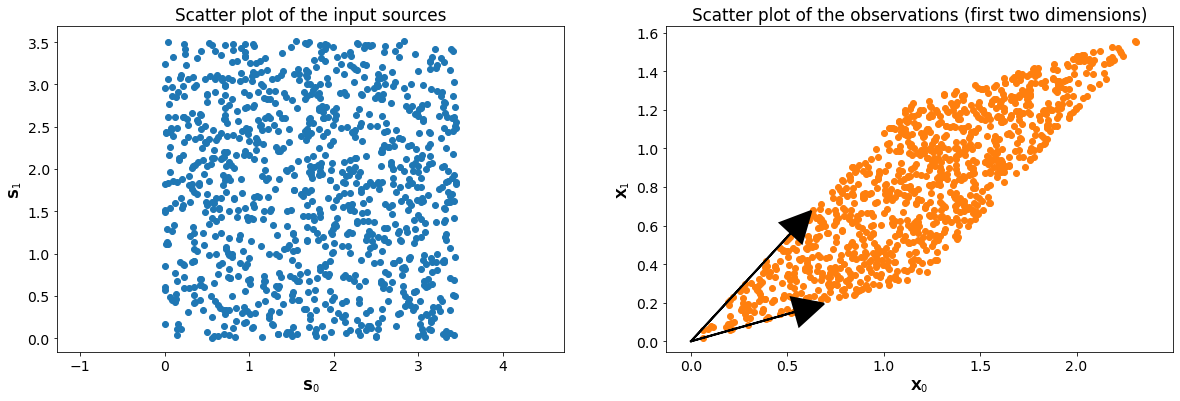

In [8]:
# Generate data

n = 2         # number of sources
m = 8         # number of observations
t = 1024      # number of samples

s_type = 2

X, A, S = bss.makeMixture(s_type=s_type, nneg=True, n=n, m=m, t=t)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
#means = np.mean(X, axis=1)
plt.arrow(0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow(0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

### Geometric approach (not tackled in this notebook)

The convex cone generated by a set of vectors $\{\mathbf{s}_i, i\in[1,n]\}$ is defined by $\mathcal{C} = \left\{\mathbf{x} = \sum\limits_{i=1}^{n} a_i \mathbf{s}_i, \forall i\in[1,n], a_i\in\mathbb{R}^+\right\}$.

In the context of NMF, due to the non-negative hypotheses, the observations belong to the convex cone generated by the sources, which itself is included in the positive orthant.

<img src="img/geo_approach.png" width="600"/>

The geometric approaches aim at finding a convex cone within the positive orthant that contains all the observations. If the observations are projected on the simplex plane, the problem can be recast as finding a polytope which contains all the observations. 

<img src="img/geo_approach_2.png" width="600"/>

If, for each source, there is at least one sample where this source only is active, it is possible to perform the separation exactly. This is known as the pure-pixel assumption.


### Optimization approach

Minimize a cost function:
$$\min\limits_{\mathbf{A}\geq0,\mathbf{S}\geq0} \text{D}(\mathbf{X}, \mathbf{AS}),$$
where D is a divergence (e.g. Euclidian distance or Kullback-Leibler divergence) and $\mathbf{M}\geq0$ means that the coefficients of $\mathbf{M}$ are non-negative.

A standard minimization procedure is the "multiplicative update" (Lee & Seung 1999). At each iteration, $\mathbf{A}$ and $\mathbf{S}$ in a way that decreases the cost function. For instance, in the case of the Euclidian distance ($\text{D} = ||\mathbf{X} -\mathbf{AS}||^2_\text{F}$), the updates are:
- $\mathbf{S}_i^j \leftarrow \mathbf{S}_i^j \dfrac{(\mathbf{A}^T\mathbf{X})_i^j}{(\mathbf{A}^T\mathbf{AS})_i^j}$
- $\mathbf{A}_i^j \leftarrow \mathbf{A}_i^j \dfrac{(\mathbf{XS}^T)_i^j}{(\mathbf{ASS}^T)_i^j}$

Another popular algorithm is Hierarchical Alternating Least Squares or HALS (Cichocki, 2007). It is also implemented by a multiplicative update, but the columns of $\mathbf{A}$ and the lines of $\mathbf{S}$ are updated one by one iteratively.

Let us compare these two methods.

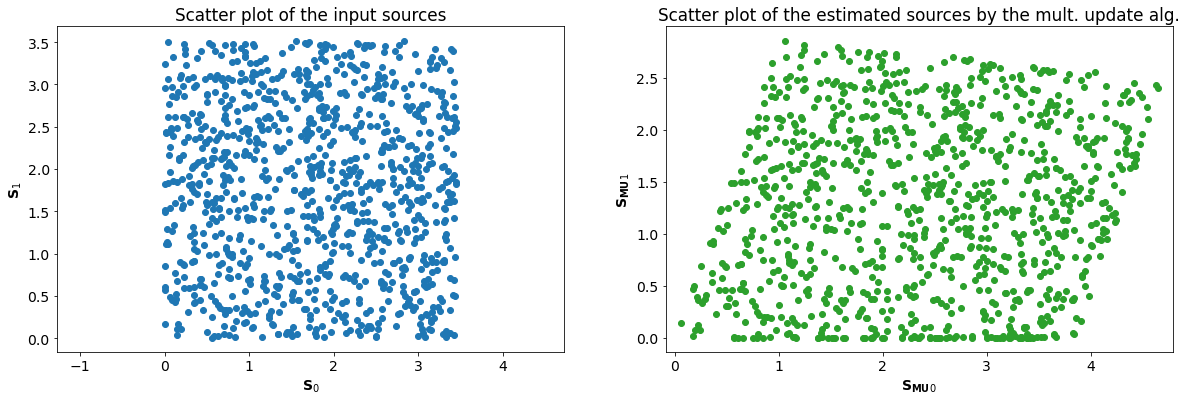

In [9]:
# Unmix the sources with the multiplicative update algorithm

A_mu, S_mu = bss.multiplicative_update(X, n)
bss.corr_perm(A, S, A_mu, S_mu, inplace=True)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by the mult. update alg.')
plt.plot(S_mu[0,:], S_mu[1,:],'C2o',zorder=0)
plt.xlabel("$\mathbf{S_{MU}}_0$")
plt.ylabel("$\mathbf{S_{MU}}_1$");
plt.axis('equal');

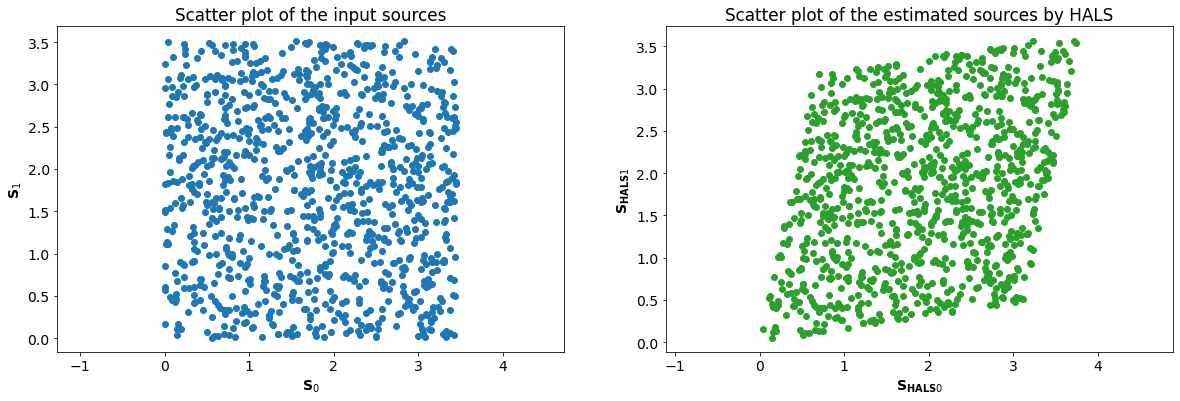

In [10]:
# Unmix the sources with HALS

A_hals, S_hals = bss.hals(X, n=n)
bss.corr_perm(A, S, A_hals, S_hals, inplace=True)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');


fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by HALS')
plt.plot(S_hals[0,:], S_hals[1,:],'C2o',zorder=0)
plt.xlabel("$\mathbf{S_{HALS}}_0$")
plt.ylabel("$\mathbf{S_{HALS}}_1$");
plt.axis('equal');

In [11]:
print("Multiplicative update:\n- NMSE: %.2f dB\n- CA: %.2f dB\n" % (bss.nmse(S, S_mu), bss.ca(A, A_mu)))
print("HALS:\n- NMSE: %.2f dB\n- CA: %.2f dB" % (bss.nmse(S, S_hals), bss.ca(A, A_hals)))

Multiplicative update:
- NMSE: 10.09 dB
- CA: 7.90 dB

HALS:
- NMSE: 18.69 dB
- CA: 8.91 dB


<b>Next:</b> [5. Sparse matrix factorization: the GMCA example](./5_Sparse_Matrix_Factorization_GMCA.ipynb)